In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# SVM on pattern pixels, predicted ROI, one area

In [1]:
from matplotlib import pyplot as plt
import cv2
import pandas as pd
import numpy as np
import os
import ast
from skimage.morphology import skeletonize


def to_tuple(t):
    return ast.literal_eval(t)
 
def unique_color(img):
    mask = img > 0
    only_color = img[mask]
    colors, count = np.unique(only_color, return_counts=True)
    max_color = colors[count.argmax()]
    #print(max_color)
    img[np.logical_not(mask)] = max_color
    return img

def maxDeviationThresh(hist):
    maximum = max(hist)
    index_max = list(hist).index(maximum)
    index_min = 0
    for i in range(0, index_max):
        if not hist[i] and hist[i + 1]:
            index_min = i
            break

    distances = []
    x1 = index_min
    y1 = hist[index_min]
    x2 = index_max
    y2 = hist[index_max]
    for i in range(index_min + 1, index_max):
        x0 = i
        y0 = hist[i]
        distance = np.abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1) / np.sqrt(
            (y2 - y1) ** 2 + (x2 - x1) ** 2)
        distances.append(distance)
    if index_min < index_max - 1:
        T_index = distances.index(max(distances))
    else:
        T_index = -index_min
    return T_index + index_min


def extract_drawing(image):
    dst = cv2.bilateralFilter(image, 10, sigmaColor=15, sigmaSpace=15)
    # dst = img.copy()
    # max_occ = np.bincount(dst[dst > 0]).argmax()
    # dst[dst == 0] = max_occ
    threshed = np.ones(dst.shape, np.uint8) * 255
    if np.any(dst < 255):
        hist, _ = np.histogram(dst[dst < 255].flatten(), range(257))
        thresh_val = maxDeviationThresh(hist)
        #print(thresh_val)
        mask = dst < thresh_val
        threshed[mask] = 0
    return threshed

def getBackground(external, img, morph=True, ret_hier=False):
    background = np.zeros_like(img)
    points = np.array([external]).reshape((4, 1, 2))
    background = cv2.fillConvexPoly(background, points, (255, 255, 255))
    not_background = cv2.bitwise_not(background)
    background = cv2.bitwise_and(img, background)
    overlap = cv2.polylines(cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2RGB), [points], True, (255, 0, 0), 1)
    #plt.imshow(overlap)
    #plt.show()
    # background[background == 0] = 255
    # background = extract_drawing(background)
    background= cv2.bitwise_or(not_background, background)
    if morph:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
        # background = cv2.bitwise_not(background)
        background = cv2.bitwise_not(cv2.erode(background, kernel))
        background = skeletonize(background / 255, method='lee').astype(np.uint8)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        background = cv2.dilate(background, kernel)
    else:
        background = cv2.bitwise_not(background)
        background = skeletonize(background / 255, method='lee').astype(np.uint8)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        background = cv2.dilate(background, kernel)
    #plt.imshow(background, cmap='gray')
    #plt.show()
    cnts, hier = cv2.findContours(background, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if ret_hier:
        return background, cnts, hier
    else:
        return background, cnts

In [2]:


root = '../' #modificare se cartella rinominata
results_folder = os.path.join(root, 'results')
training_folder = os.path.join(root, 'dataset', 'training')
df_rail = pd.read_csv(os.path.join(results_folder, 'scores.csv'), header=0, usecols=['names', 'rect'], index_col='names', converters={'rect': to_tuple})
plt.rcParams['figure.figsize'] = [10, 5]
pixels = []

dataset = pd.read_csv(os.path.join(training_folder, 'DatabaseScoreByHand_training.csv'), header=0, index_col='CODICE', delimiter=',')
# print(linee_d.value_counts())
scoring=np.zeros(4)
hom_folder = os.path.join(root, 'dataset', 'threshed')
file_homog = pd.read_json(os.path.join(hom_folder, 'points.txt'), lines=True).set_index('name')

patterns = ['PATTERN5', 'PATTERN10', 'PATTERN12', 'PATTERN18', 'PATTERN3', 'PATTERN15', 'PATTERN17' ]
patternsName = ['cross', 'face', 'rail', 'triangle', 'rett_diag', 'rect', 'cross_vert']

y_data = []
X = [] 

for i in range(len(patterns)):
  coords = [852, 229, 1031, 531]#cambiare qui
  y_data.append([])
  X.append([])
  linee_d = dataset.loc[:, patterns[i]] #cambiare qui
  for img_path in os.listdir(hom_folder):
      if img_path.lower().endswith('.png'):
        name = img_path[:-4]      
        if name in linee_d.index:
          score = int(linee_d.loc[name])       
          scoring[score] += 1
          if score == 0:
            y_data[i].append(0)
            img = cv2.imread(os.path.join(hom_folder, img_path), cv2.IMREAD_GRAYSCALE)
            img = cv2.blur(img, (5, 5))
            if img_path[:-4] in df_rail.index:
              rail_bbox = df_rail.loc[img_path[:-4]].values[0][i]
              external = [(rail_bbox[0], rail_bbox[1]), (rail_bbox[0]+rail_bbox[2], rail_bbox[1]), (rail_bbox[0]+rail_bbox[2], rail_bbox[1]+rail_bbox[3]), (rail_bbox[0], rail_bbox[1]+rail_bbox[3])]
              background, _ = getBackground(external, img, False)
              pixel = np.sum(np.divide(background, 255))
              print('pixels {}'.format(pixel))
              img = cv2.rectangle(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB), (rail_bbox[0], rail_bbox[1]), (rail_bbox[0]+rail_bbox[2], rail_bbox[1]+rail_bbox[3]), (255,0,0), 3)
              X[i].append([pixel])
            # else:
            #   x = coords[0] 
            #   y = coords[1] 
            #   w = np.abs(coords[0] - coords[2])
            #   h = np.abs(coords[1] - coords[3])
            #   external = [(x, y), (x+w, y), (x+w, y+h), (x, y+h)]
            #   background, _ = getBackground(external, img, False)
            #   pixel = np.sum(np.divide(background, 255))
            #   # print('pixels {}'.format(pixel))
            #   X[i].append([0, pixel])
            # print('score 0, pixels {}'.format(pixel))
            
          else:
            y_data[i].append(1)
            img = cv2.imread(os.path.join(hom_folder, img_path), cv2.IMREAD_GRAYSCALE)
            img = cv2.blur(img, (5, 5))
            if img_path[:-4] in df_rail.index:
              rail_bbox = df_rail.loc[img_path[:-4]].values[0][i]
              external = [(rail_bbox[0], rail_bbox[1]), (rail_bbox[0]+rail_bbox[2], rail_bbox[1]), (rail_bbox[0]+rail_bbox[2], rail_bbox[1]+rail_bbox[3]), (rail_bbox[0], rail_bbox[1]+rail_bbox[3])]
              background, _ = getBackground(external, img, False)
              pixel = np.sum(np.divide(background, 255))
              print('pixels {}'.format(pixel))
              img = cv2.rectangle(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB), (rail_bbox[0], rail_bbox[1]), (rail_bbox[0]+rail_bbox[2], rail_bbox[1]+rail_bbox[3]), (255,0,0), 3)
              X[i].append([pixel])
            # else:
            #   x = coords[0] 
            #   y = coords[1] 
            #   w = np.abs(coords[0] - coords[2])
            #   h = np.abs(coords[1] - coords[3])
            #   external = [(x, y), (x+w, y), (x+w, y+h), (x, y+h)]
            #   background, _ = getBackground(external, img, False)
            #   pixel = np.sum(np.divide(background, 255))
            #   # print('pixels {}'.format(pixel))
            #   X[i].append([0, pixel])
            # print('score 1, pixels {}'.format(pixel))


  # print(scoring)
  X[i] = np.array(X[i])
  y_data[i] = np.array(y_data[i])
  print(X[i].shape, y_data[i].shape)
  print("done ", patterns[i], " ", patternsName[i])
            



pixels 1417.0
pixels 1355.0
pixels 826.0
pixels 973.0
pixels 869.0
pixels 982.0
pixels 730.1176470588239
pixels 1197.0
pixels 969.0
pixels 1092.0
pixels 804.6431372549009
pixels 1074.0
pixels 1195.0
pixels 584.8078431372547
pixels 869.0
pixels 791.0
pixels 798.4117647058819
pixels 642.101960784314
pixels 294.0
pixels 933.0
pixels 819.2745098039218
pixels 826.0
pixels 1530.0
pixels 987.0
pixels 1074.0
pixels 1062.0
pixels 1012.0
pixels 1530.0
pixels 858.0
pixels 1031.0
pixels 4.8313725490196076
pixels 968.0313725490189
pixels 872.2823529411754
pixels 1107.0
pixels 726.0
pixels 906.0196078431369
pixels 972.0
pixels 149.0
pixels 1064.0
pixels 626.0
pixels 48.16862745098039
pixels 984.7999999999998
pixels 832.0
pixels 1005.0
pixels 845.0
pixels 877.0
pixels 1452.0
pixels 1024.0
pixels 1021.3137254901953
pixels 855.0
pixels 880.0
pixels 805.0
pixels 1093.0
pixels 895.0
pixels 1144.0
pixels 1021.0
pixels 1489.0
pixels 1211.0
pixels 845.0
pixels 186.0
pixels 879.1176470588231
pixels 621.0
pix

SVM FOR  cross
poly done
rbf done
sigmoid done
Best model with poly kernel:
SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced', coef0=5.0,
    decision_function_shape='ovr', degree=4, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.7995139876718824
train score: 0.7745098039215685
test score: 0.7076666666666667

cv score: 0.7995139876718824
train score: 0.8634146341463415
test score: 0.8102189781021898

Confusion matrix, without normalization
[[  7   5]
 [ 21 104]]


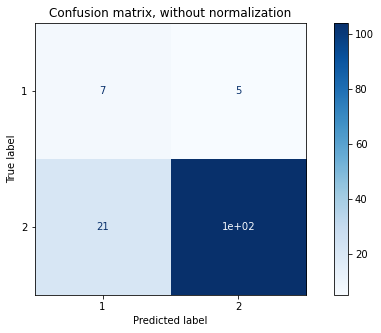

Normalized confusion matrix
[[0.58333333 0.41666667]
 [0.168      0.832     ]]


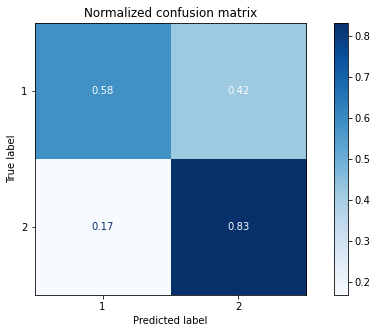

Best model with rbf kernel:
SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.7942508297771456
train score: 0.7798573975044563
test score: 0.6739999999999999

cv score: 0.7942508297771456
train score: 0.8731707317073171
test score: 0.8175182481751825

Confusion matrix, without normalization
[[  6   6]
 [ 19 106]]


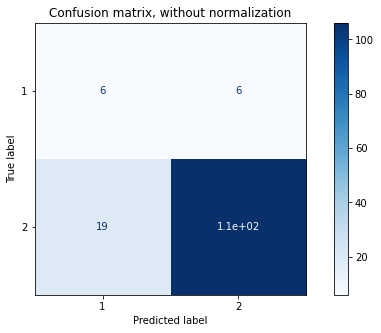

Normalized confusion matrix
[[0.5   0.5  ]
 [0.152 0.848]]


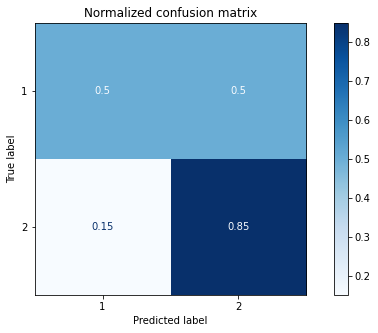

Best model with sigmoid kernel:
SVC(C=100, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.7772878141299195
train score: 0.7745098039215685
test score: 0.7076666666666667

cv score: 0.7772878141299195
train score: 0.8634146341463415
test score: 0.8102189781021898

Confusion matrix, without normalization
[[  7   5]
 [ 21 104]]


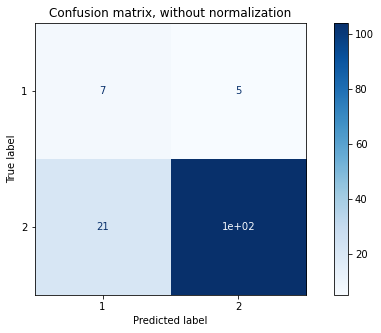

Normalized confusion matrix
[[0.58333333 0.41666667]
 [0.168      0.832     ]]


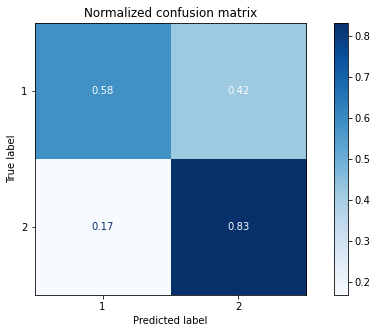

SVM FOR  face
poly done
rbf done
sigmoid done
Best model with poly kernel:
SVC(C=0.01, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=-10.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.735897435897436
train score: 0.7692307692307693
test score: 0.6587912087912088

cv score: 0.735897435897436
train score: 0.7414634146341463
test score: 0.7372262773722628

Confusion matrix, without normalization
[[ 4  3]
 [33 97]]


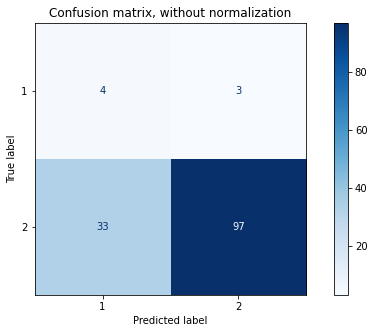

Normalized confusion matrix
[[0.57142857 0.42857143]
 [0.25384615 0.74615385]]


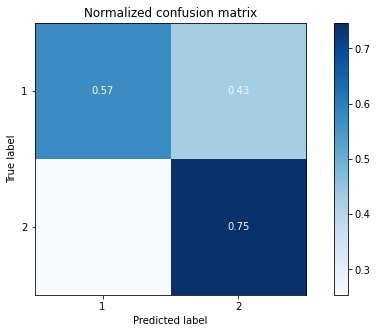

Best model with rbf kernel:
SVC(C=100, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.7435897435897435
train score: 0.7461538461538462
test score: 0.6686813186813187

cv score: 0.7435897435897435
train score: 0.697560975609756
test score: 0.6277372262773723

Confusion matrix, without normalization
[[ 5  2]
 [49 81]]


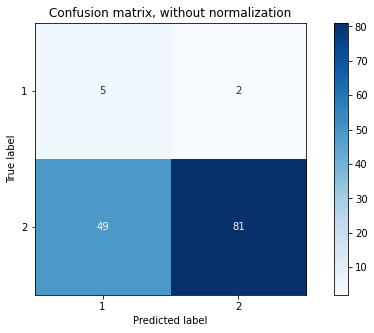

Normalized confusion matrix
[[0.71428571 0.28571429]
 [0.37692308 0.62307692]]


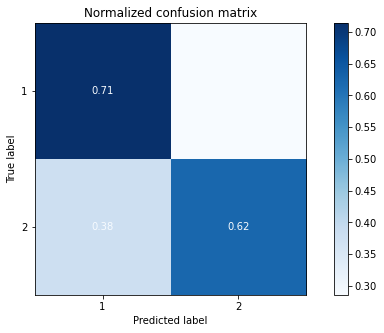

Best model with sigmoid kernel:
SVC(C=100, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.7487179487179488
train score: 0.6705128205128206
test score: 0.660989010989011

cv score: 0.7487179487179488
train score: 0.6439024390243903
test score: 0.6131386861313869

Confusion matrix, without normalization
[[ 5  2]
 [51 79]]


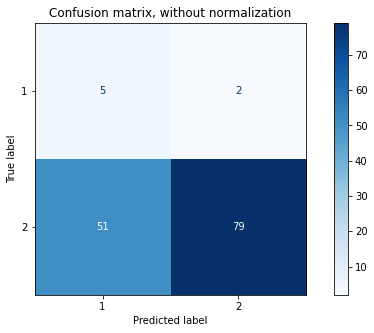

Normalized confusion matrix
[[0.71428571 0.28571429]
 [0.39230769 0.60769231]]


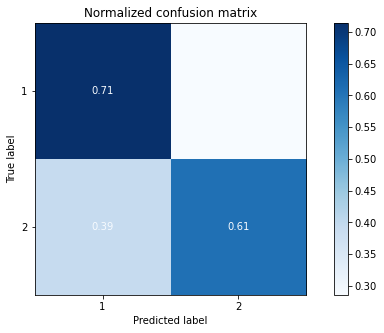

SVM FOR  rail
poly done
rbf done
sigmoid done
Best model with poly kernel:
SVC(C=1000, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=10.0, decision_function_shape='ovr', degree=4, gamma='scale',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.5923076923076923
train score: 0.5435897435897437
test score: 0.4917582417582418

cv score: 0.5923076923076923
train score: 0.3121951219512195
test score: 0.291970802919708

Confusion matrix, without normalization
[[ 5  2]
 [95 35]]


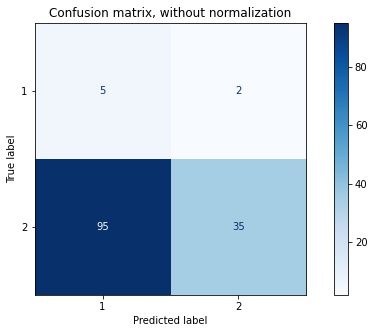

Normalized confusion matrix
[[0.71428571 0.28571429]
 [0.73076923 0.26923077]]


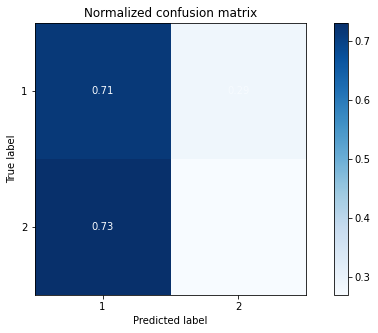

Best model with rbf kernel:
SVC(C=10, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.6256410256410256
train score: 0.5987179487179487
test score: 0.6120879120879121

cv score: 0.6256410256410256
train score: 0.8682926829268293
test score: 0.9051094890510949

Confusion matrix, without normalization
[[  2   5]
 [  8 122]]


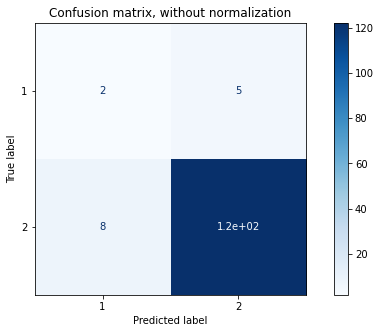

Normalized confusion matrix
[[0.28571429 0.71428571]
 [0.06153846 0.93846154]]


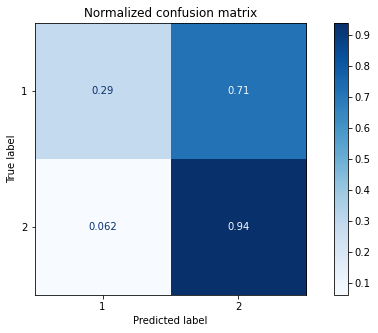

Best model with sigmoid kernel:
SVC(C=10, break_ties=False, cache_size=200, class_weight='balanced', coef0=5.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.6307692307692309
train score: 0.5948717948717949
test score: 0.6450549450549451

cv score: 0.6307692307692309
train score: 0.7707317073170732
test score: 0.8394160583941606

Confusion matrix, without normalization
[[  3   4]
 [ 18 112]]


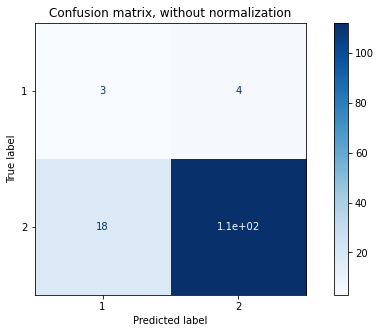

Normalized confusion matrix
[[0.42857143 0.57142857]
 [0.13846154 0.86153846]]


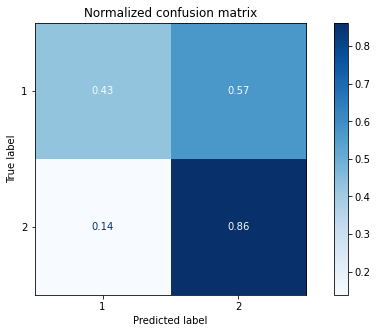

SVM FOR  triangle
poly done
rbf done
sigmoid done
Best model with poly kernel:
SVC(C=0.01, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=-5.0, decision_function_shape='ovr', degree=4, gamma='scale',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.7550000000000001
train score: 0.6575
test score: 0.7142857142857143

cv score: 0.7550000000000001
train score: 0.5219512195121951
test score: 0.44525547445255476

Confusion matrix, without normalization
[[ 4  0]
 [76 57]]


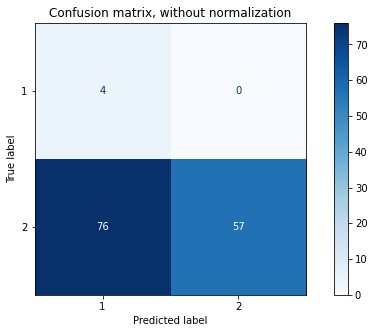

Normalized confusion matrix
[[1.         0.        ]
 [0.57142857 0.42857143]]


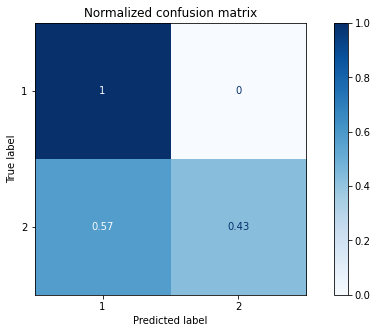

Best model with rbf kernel:
SVC(C=100, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.61
train score: 0.6725
test score: 0.7236842105263157

cv score: 0.61
train score: 0.9317073170731708
test score: 0.9343065693430657

Confusion matrix, without normalization
[[  2   2]
 [  7 126]]


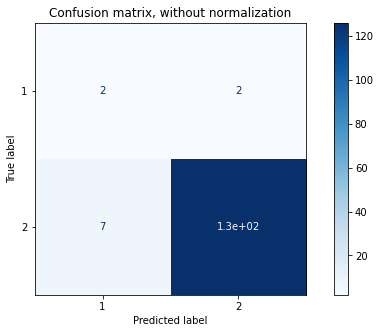

Normalized confusion matrix
[[0.5        0.5       ]
 [0.05263158 0.94736842]]


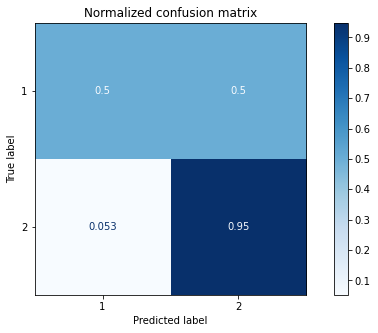

Best model with sigmoid kernel:
SVC(C=10, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=-10.0, decision_function_shape='ovr', degree=3, gamma=0.01,
    kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.6300000000000001
train score: 0.63
test score: 0.6992481203007519

cv score: 0.6300000000000001
train score: 0.4682926829268293
test score: 0.41605839416058393

Confusion matrix, without normalization
[[ 4  0]
 [80 53]]


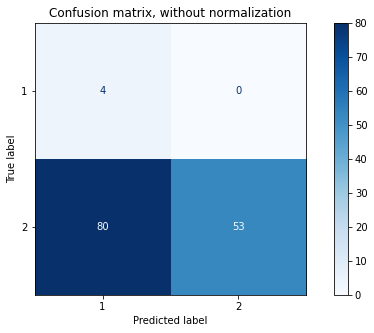

Normalized confusion matrix
[[1.         0.        ]
 [0.60150376 0.39849624]]


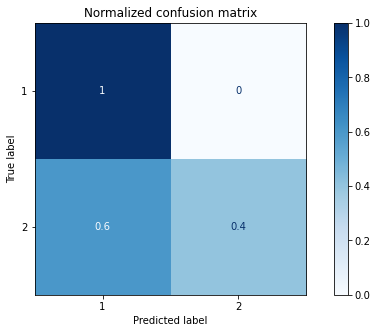

SVM FOR  rett_diag
poly done
rbf done
sigmoid done
Best model with poly kernel:
SVC(C=0.01, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.8771794871794872
train score: 0.8521573604060914
test score: 0.8861323155216285

cv score: 0.8771794871794872
train score: 0.9463414634146341
test score: 0.9343065693430657

Confusion matrix, without normalization
[[  5   1]
 [  8 123]]


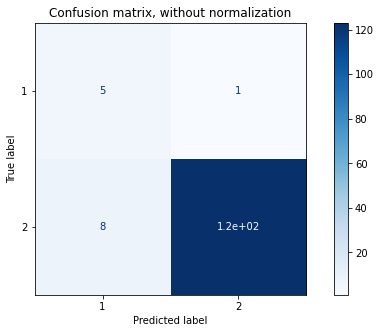

Normalized confusion matrix
[[0.83333333 0.16666667]
 [0.0610687  0.9389313 ]]


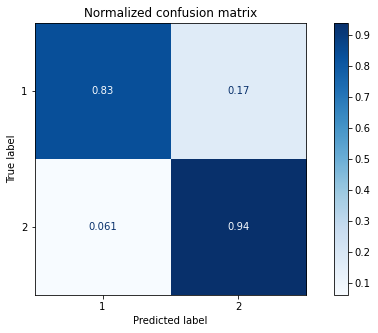

Best model with rbf kernel:
SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.8787820512820513
train score: 0.8613578680203046
test score: 0.916030534351145

cv score: 0.8787820512820513
train score: 0.848780487804878
test score: 0.8394160583941606

Confusion matrix, without normalization
[[  6   0]
 [ 22 109]]


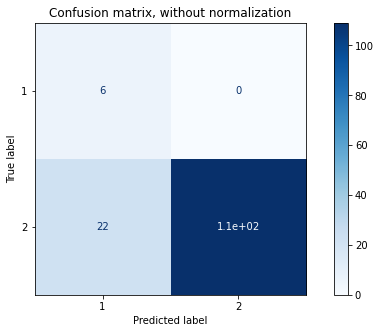

Normalized confusion matrix
[[1.         0.        ]
 [0.16793893 0.83206107]]


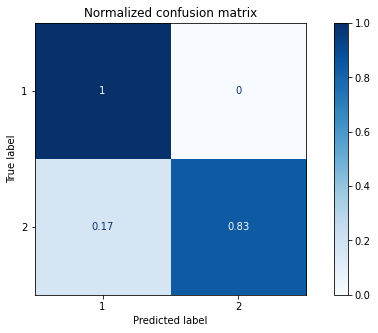

Best model with sigmoid kernel:
SVC(C=1000, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=-5.0, decision_function_shape='ovr', degree=3, gamma=0.1,
    kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.8967307692307692
train score: 0.8842005076142132
test score: 0.9465648854961832

cv score: 0.8967307692307692
train score: 0.8926829268292683
test score: 0.8978102189781022

Confusion matrix, without normalization
[[  6   0]
 [ 14 117]]


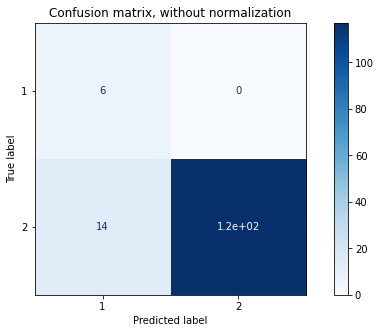

Normalized confusion matrix
[[1.         0.        ]
 [0.10687023 0.89312977]]


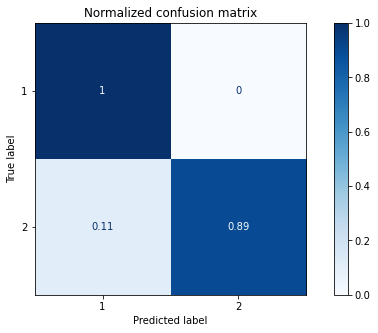

SVM FOR  rect
poly done
rbf done
sigmoid done
Best model with poly kernel:
SVC(C=0.01, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=4, gamma='scale',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.8749358974358975
train score: 0.8915410385259632
test score: 0.48120300751879697

cv score: 0.8749358974358975
train score: 0.9463414634146341
test score: 0.9343065693430657

Confusion matrix, without normalization
[[  0   4]
 [  5 128]]


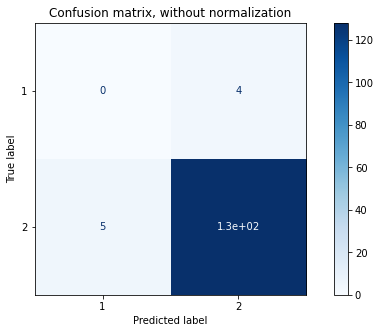

Normalized confusion matrix
[[0.         1.        ]
 [0.03759398 0.96240602]]


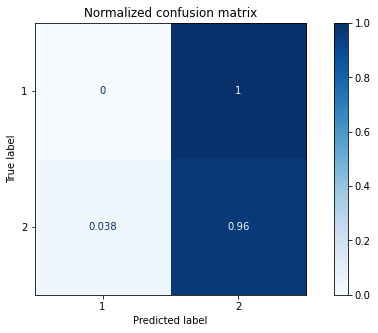

Best model with rbf kernel:
SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.814551282051282
train score: 0.8362646566164154
test score: 0.5347744360902256

cv score: 0.814551282051282
train score: 0.8390243902439024
test score: 0.8029197080291971

Confusion matrix, without normalization
[[  1   3]
 [ 24 109]]


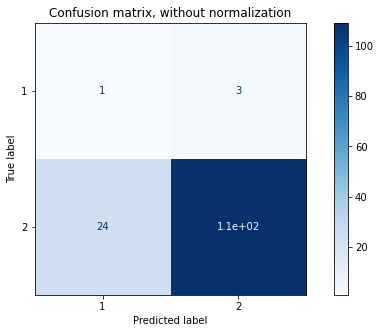

Normalized confusion matrix
[[0.25       0.75      ]
 [0.18045113 0.81954887]]


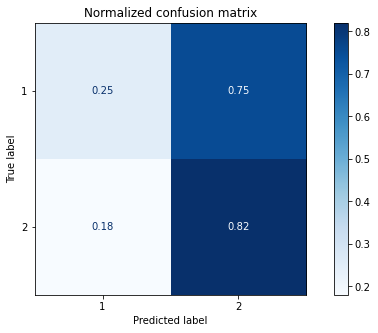

Best model with sigmoid kernel:
SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.7943589743589744
train score: 0.8312395309882747
test score: 0.5272556390977443

cv score: 0.7943589743589744
train score: 0.8292682926829268
test score: 0.7883211678832117

Confusion matrix, without normalization
[[  1   3]
 [ 26 107]]


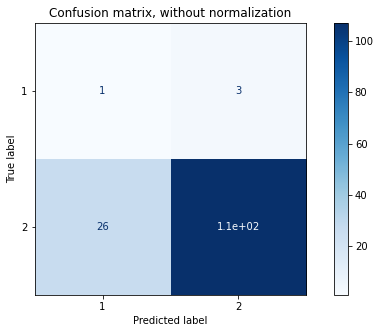

Normalized confusion matrix
[[0.25       0.75      ]
 [0.19548872 0.80451128]]


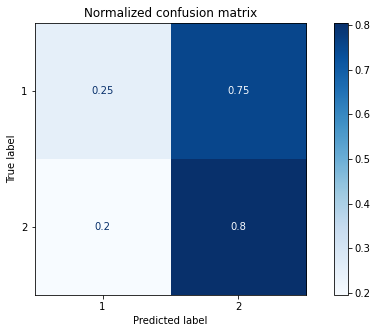

SVM FOR  cross_vert
poly done
rbf done
sigmoid done
Best model with poly kernel:
SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=-10.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.6460897435897437
train score: 0.5688451776649746
test score: 0.3462121212121212

cv score: 0.6460897435897437
train score: 0.5170731707317073
test score: 0.48175182481751827

Confusion matrix, without normalization
[[ 1  4]
 [67 65]]


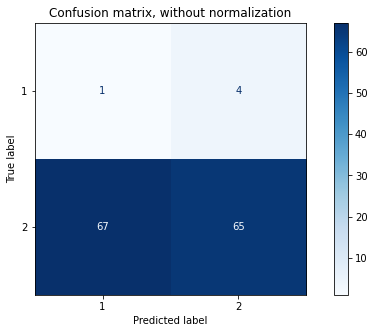

Normalized confusion matrix
[[0.2        0.8       ]
 [0.50757576 0.49242424]]


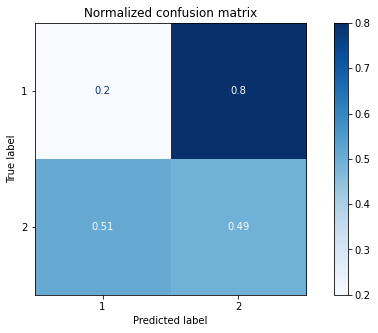

Best model with rbf kernel:
SVC(C=100, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.6494230769230768
train score: 0.6348350253807107
test score: 0.7143939393939394

cv score: 0.6494230769230768
train score: 0.6439024390243903
test score: 0.635036496350365

Confusion matrix, without normalization
[[ 4  1]
 [49 83]]


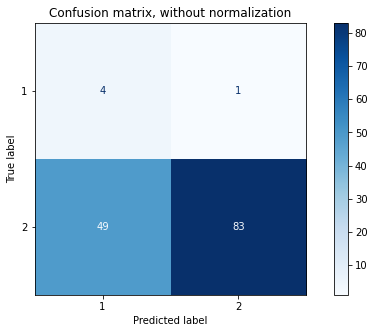

Normalized confusion matrix
[[0.8        0.2       ]
 [0.37121212 0.62878788]]


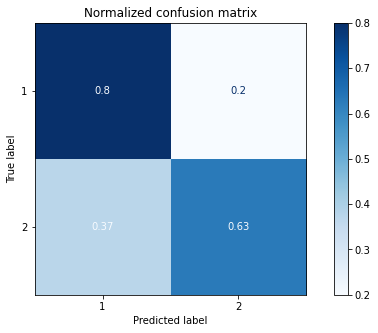

Best model with sigmoid kernel:
SVC(C=10, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.7419871794871794
train score: 0.7024111675126903
test score: 0.5181818181818182

cv score: 0.7419871794871794
train score: 0.6585365853658537
test score: 0.6277372262773723

Confusion matrix, without normalization
[[ 2  3]
 [48 84]]


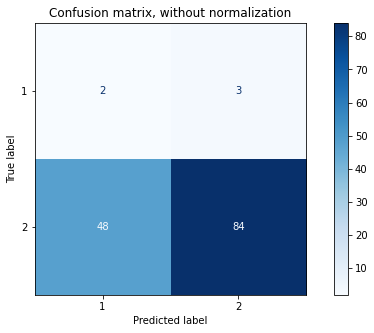

Normalized confusion matrix
[[0.4        0.6       ]
 [0.36363636 0.63636364]]


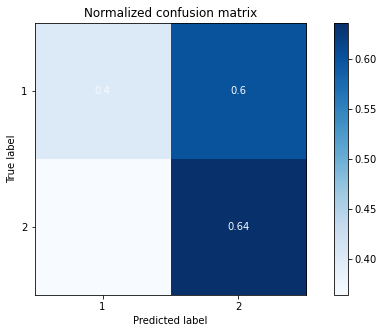

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix, matthews_corrcoef, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions
import joblib
y = y_data
for i in range(len(patterns)):

    print("SVM FOR ", patternsName[i])
    X_pixel = X[i]
    y_current = y[i]
    X_train, X_test, y_train, y_test = train_test_split(X_pixel, y_current, test_size=0.4, random_state=0, stratify=y_current)
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],
        'coef0': np.linspace(-10, 10, 5),
        'degree': [2, 3, 4]}
    svm_poly_pixel = GridSearchCV(SVC(kernel='poly', class_weight='balanced'), param_grid,
                            cv=5, scoring='balanced_accuracy', refit=True)
    svm_poly_pixel.fit(X_train_scaled, y_train)
    print('poly done')
    # RBF
    param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
    rbf_poly_pixel = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, 
                            cv=5, scoring='balanced_accuracy', refit=True)
    rbf_poly_pixel.fit(X_train_scaled, y_train)
    print('rbf done')
    # Sigmoid
    param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'coef0': np.linspace(-10, 10, 5)}
    sigm_poly_pixel = GridSearchCV(SVC(kernel='sigmoid', class_weight='balanced'), param_grid, 
                            cv=5, scoring='balanced_accuracy', refit=True)
    sigm_poly_pixel.fit(X_train_scaled, y_train)
    print('sigmoid done')
    for m in [svm_poly_pixel, rbf_poly_pixel, sigm_poly_pixel]:
        cv_score = m.best_score_
        m = m.best_estimator_  
        print("Best model with {} kernel:".format(m.get_params()['kernel']))    
        print(m)     
        train_acc = balanced_accuracy_score(y_train, m.predict(X_train_scaled))
        test_acc = balanced_accuracy_score(y_test, m.predict(X_test_scaled))
        print("cv score: {}".format(cv_score))
        print("train score: {}".format(train_acc))
        print("test score: {}\n".format(test_acc))
        train_acc = accuracy_score(y_train, m.predict(X_train_scaled))
        test_acc = accuracy_score(y_test, m.predict(X_test_scaled))
        print("cv score: {}".format(cv_score))
        print("train score: {}".format(train_acc))
        print("test score: {}\n".format(test_acc))
        # plot_decision_regions(X_test_scaled, y_test, clf=m, legend=2)
        titles_options = [("Confusion matrix, without normalization", None),
                    ("Normalized confusion matrix", 'true')]
        class_names = ['1', '2']
        for title, normalize in titles_options:
            disp = plot_confusion_matrix(m, X_test_scaled, y_test,
                                        display_labels=class_names,
                                        cmap=plt.cm.Blues,
                                        normalize=normalize)
            disp.ax_.set_title(title)
            print(title)
            print(disp.confusion_matrix)
            plt.show()
            plt.close('all')
        
        # joblib.dump(m, '../new_models/'+ patternsName[i] +'_model_' + m.get_params()['kernel'] + '.joblib')
    # joblib.dump(scaler, '../new_models/'+patternsName[i] +'_scaler.joblib')



# SVM on pattern pixels, from hardcoded ROIs, one area

In [4]:
import cv2
p_dst = [(382, 219),(852, 219), (852, 537), (382, 537)]
def computeHomographyRhomb( points):
    point_rhomb = points[2] + (1,)
    mask = np.ones(5, dtype=int)
    mask[2] = 0
    right_points = np.array(points)[np.ma.make_mask(mask)]
    hm, status = cv2.findHomography(np.array(right_points), np.array(p_dst))
    new_point = np.dot(hm, point_rhomb)
    new_point = tuple(np.round(new_point/new_point[2]).astype(int))
    center = new_point[0:2]
    return center

In [6]:


root = '../' #modificare se cartella rinominata
results_folder = os.path.join(root, 'results')
training_folder = os.path.join(root, 'dataset', 'training')
df_rail = pd.read_csv(os.path.join(results_folder, 'scores.csv'), header=0, usecols=['names', 'rect'], index_col='names', converters={'rect': to_tuple})
plt.rcParams['figure.figsize'] = [10, 5]
pixels = []

dataset = pd.read_csv(os.path.join(training_folder, 'DatabaseScoreByHand_training.csv'), header=0, index_col='CODICE', delimiter=',')
# print(linee_d.value_counts())
scoring=np.zeros(4)
hom_folder = os.path.join(root, 'dataset', 'threshed')
file_homog = pd.read_json(os.path.join(hom_folder, 'points.txt'), lines=True).set_index('name')

patterns = ['PATTERN5', 'PATTERN10', 'PATTERN12', 'PATTERN18', 'PATTERN3', 'PATTERN15', 'PATTERN17' ]
patternsName = ['cross', 'face', 'rail', 'triangle', 'rett_diag', 'rect', 'cross_vert']
coordinatesROI =  [
    [324,119,378,373],
    [742, 287, 829, 373],
    [617, 383, 847, 534],
    [852, 229, 531],
    [379, 300, 502, 456],
    [360, 525, 510, 680],
    [502, 540, 810, 661]
]

y_data = []
X = [] 

for i in range(len(patterns)):
  coords = [852, 229, 1031, 531]#cambiare qui
  y_data.append([])
  X.append([])
  linee_d = dataset.loc[:, patterns[i]] #cambiare qui
  for img_path in os.listdir(hom_folder):
      if img_path.lower().endswith('.png'):
        name = img_path[:-4]      
        if name in linee_d.index:
          score = int(linee_d.loc[name])       
          scoring[score] += 1
          if i == 3:
            points = file_homog.loc[name].values[0]
            points = [tuple(x) for x in points]
            r_points = computeHomographyRhomb(points)
            coordinatesROI[3].insert(2, r_points[0])
          if score == 0:
            y_data[i].append(0)
            img = cv2.imread(os.path.join(hom_folder, img_path), cv2.IMREAD_GRAYSCALE)
            img = cv2.blur(img, (5, 5))
            if img_path[:-4] in df_rail.index:
              # rail_bbox = df_rail.loc[img_path[:-4]].values[0][i]
              rail_bbox = coordinatesROI[i]
              external = [(rail_bbox[0], rail_bbox[1]), (rail_bbox[2], rail_bbox[1]), (rail_bbox[2], rail_bbox[3]), (rail_bbox[0],rail_bbox[3])]
              background, _ = getBackground(external, img, False)
              pixel = np.sum(np.divide(background, 255))
              print('score' + str(score) + ', pixels' + str(pixel))
              img = cv2.rectangle(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB), (rail_bbox[0], rail_bbox[1]), (rail_bbox[0]+rail_bbox[2], rail_bbox[1]+rail_bbox[3]), (255,0,0), 3)
              X[i].append([pixel])
              
            # else:
            #   x = coords[0] 
            #   y = coords[1] 
            #   w = np.abs(coords[0] - coords[2])
            #   h = np.abs(coords[1] - coords[3])
            #   external = [(x, y), (x+w, y), (x+w, y+h), (x, y+h)]
            #   background, _ = getBackground(external, img, False)
            #   pixel = np.sum(np.divide(background, 255))
            #   # print('pixels {}'.format(pixel))
            #   X[i].append([0, pixel])
            # print('score 0, pixels {}'.format(pixel))
            
          else:
            y_data[i].append(1)
            img = cv2.imread(os.path.join(hom_folder, img_path), cv2.IMREAD_GRAYSCALE)
            img = cv2.blur(img, (5, 5))
            if img_path[:-4] in df_rail.index:
              rail_bbox = coordinatesROI[i]
              external = [(rail_bbox[0], rail_bbox[1]), (rail_bbox[2], rail_bbox[1]), (rail_bbox[2], rail_bbox[3]), (rail_bbox[0],rail_bbox[3])]
              background, _ = getBackground(external, img, False)
              pixel = np.sum(np.divide(background, 255))
              print('score' + str(score) + ', pixels' + str(pixel))
              img = cv2.rectangle(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB), (rail_bbox[0], rail_bbox[1]), (rail_bbox[0]+rail_bbox[2], rail_bbox[1]+rail_bbox[3]), (255,0,0), 3)
              X[i].append([pixel])
            # else:
            #   x = coords[0] 
            #   y = coords[1] 
            #   w = np.abs(coords[0] - coords[2])
            #   h = np.abs(coords[1] - coords[3])
            #   external = [(x, y), (x+w, y), (x+w, y+h), (x, y+h)]
            #   background, _ = getBackground(external, img, False)
            #   pixel = np.sum(np.divide(background, 255))
            #   # print('pixels {}'.format(pixel))
            #   X[i].append([0, pixel])
            # print('score 1, pixels {}'.format(pixel))


  # print(scoring)
  X[i] = np.array(X[i])
  y_data[i] = np.array(y_data[i])
  print(X[i].shape, y_data[i].shape)
  print("done ", patterns[i], " ", patternsName[i])
            



score2, pixels1534.0
score3, pixels1385.0
score1, pixels738.0
score1, pixels769.0
score3, pixels1307.0
score3, pixels661.0
score3, pixels795.5764705882355
score3, pixels1197.0
score3, pixels1095.0
score3, pixels1227.0
score3, pixels896.8784313725487
score0, pixels745.0
score1, pixels1199.0
score3, pixels769.9137254901968
score3, pixels646.0
score1, pixels431.35686274509806
score3, pixels1423.0
score3, pixels614.7137254901962
score1, pixels1144.0
score3, pixels957.0
score3, pixels719.7450980392159
score1, pixels1225.0
score1, pixels1388.0
score3, pixels1523.0
score3, pixels1407.0
score1, pixels835.0
score0, pixels651.0
score3, pixels1230.0
score3, pixels1340.0
score3, pixels1278.0
score3, pixels422.0
score3, pixels1372.9882352941167
score3, pixels790.588235294117
score3, pixels1239.0
score2, pixels792.0
score3, pixels1251.9019607843136
score3, pixels672.0
score0, pixels1037.0
score3, pixels549.0
score1, pixels682.0
score0, pixels773.0
score3, pixels637.5999999999997
score3, pixels1488.0

SVM FOR  cross
poly done
rbf done
sigmoid done
Best model with poly kernel:
SVC(C=0.01, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=5.0, decision_function_shape='ovr', degree=4, gamma='scale',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.8694760550023707
train score: 0.8669043374925728
test score: 0.7516666666666667

cv score: 0.8694760550023707
train score: 0.848780487804878
test score: 0.8905109489051095

Confusion matrix, without normalization
[[  7   5]
 [ 10 115]]


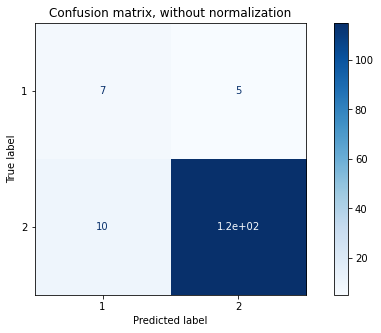

Normalized confusion matrix
[[0.58333333 0.41666667]
 [0.08       0.92      ]]


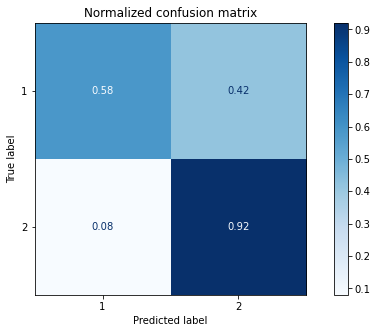

Best model with rbf kernel:
SVC(C=10, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.8694049312470364
train score: 0.8669043374925728
test score: 0.7516666666666667

cv score: 0.8694049312470364
train score: 0.848780487804878
test score: 0.8905109489051095

Confusion matrix, without normalization
[[  7   5]
 [ 10 115]]


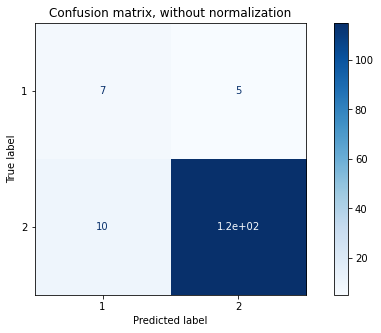

Normalized confusion matrix
[[0.58333333 0.41666667]
 [0.08       0.92      ]]


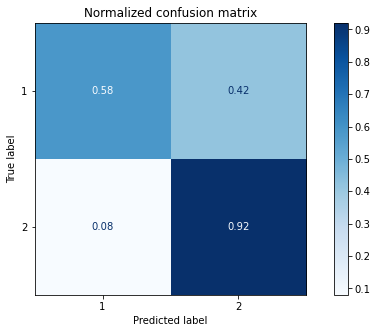

Best model with sigmoid kernel:
SVC(C=1000, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=-5.0, decision_function_shape='ovr', degree=3, gamma=0.1,
    kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.8721076339497392
train score: 0.8722519310754604
test score: 0.7516666666666667

cv score: 0.8721076339497392
train score: 0.8585365853658536
test score: 0.8905109489051095

Confusion matrix, without normalization
[[  7   5]
 [ 10 115]]


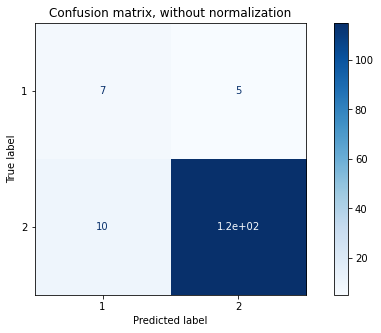

Normalized confusion matrix
[[0.58333333 0.41666667]
 [0.08       0.92      ]]


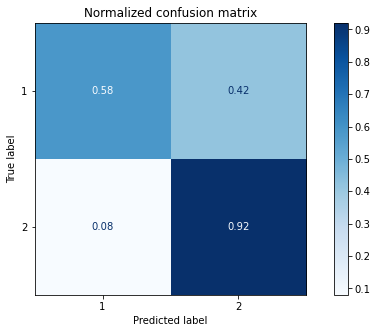

SVM FOR  face
poly done
rbf done
sigmoid done
Best model with poly kernel:
SVC(C=0.01, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=5.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.9384615384615383
train score: 0.9358974358974359
test score: 0.7802197802197802

cv score: 0.9384615384615383
train score: 0.8780487804878049
test score: 0.8394160583941606

Confusion matrix, without normalization
[[  5   2]
 [ 20 110]]


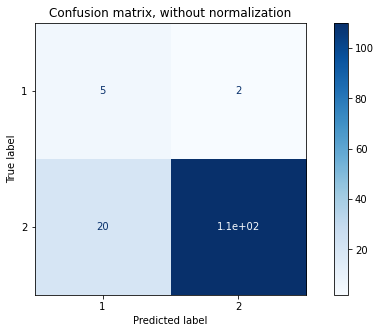

Normalized confusion matrix
[[0.71428571 0.28571429]
 [0.15384615 0.84615385]]


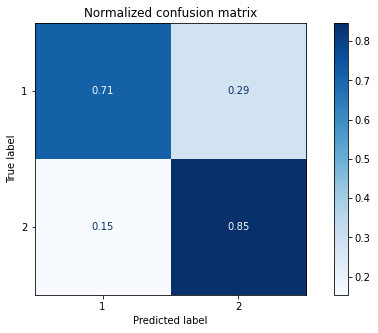

Best model with rbf kernel:
SVC(C=100, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.941025641025641
train score: 0.941025641025641
test score: 0.7956043956043957

cv score: 0.941025641025641
train score: 0.8878048780487805
test score: 0.8686131386861314

Confusion matrix, without normalization
[[  5   2]
 [ 16 114]]


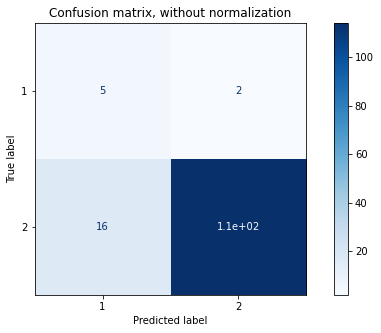

Normalized confusion matrix
[[0.71428571 0.28571429]
 [0.12307692 0.87692308]]


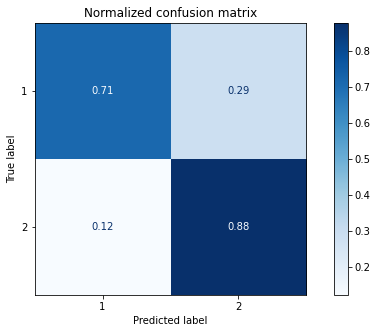

Best model with sigmoid kernel:
SVC(C=10, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.941025641025641
train score: 0.941025641025641
test score: 0.7994505494505495

cv score: 0.941025641025641
train score: 0.8878048780487805
test score: 0.8759124087591241

Confusion matrix, without normalization
[[  5   2]
 [ 15 115]]


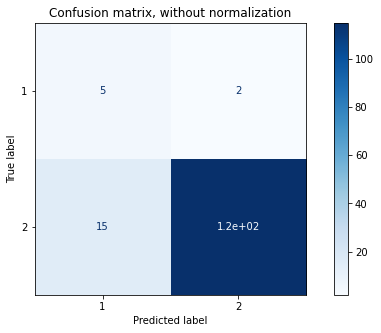

Normalized confusion matrix
[[0.71428571 0.28571429]
 [0.11538462 0.88461538]]


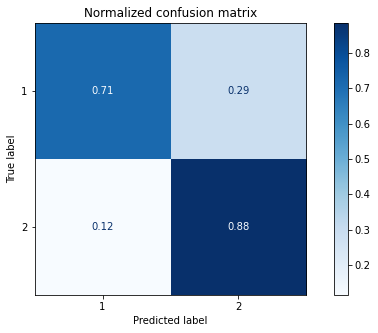

SVM FOR  rail
poly done
rbf done
sigmoid done
Best model with poly kernel:
SVC(C=0.01, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.6192307692307693
train score: 0.6192307692307693
test score: 0.6120879120879121

cv score: 0.6192307692307693
train score: 0.9073170731707317
test score: 0.9051094890510949

Confusion matrix, without normalization
[[  2   5]
 [  8 122]]


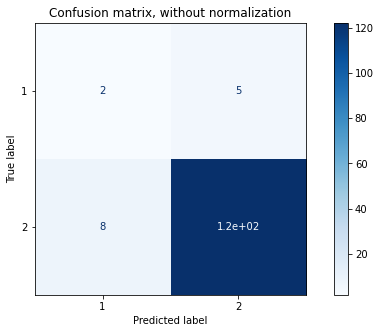

Normalized confusion matrix
[[0.28571429 0.71428571]
 [0.06153846 0.93846154]]


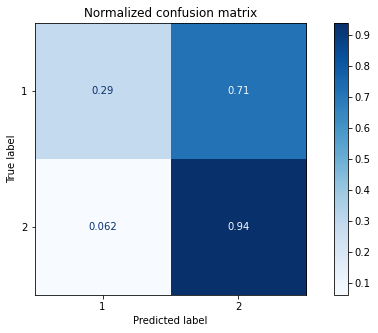

Best model with rbf kernel:
SVC(C=100, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.6461538461538461
train score: 0.6435897435897435
test score: 0.7071428571428571

cv score: 0.6461538461538461
train score: 0.6829268292682927
test score: 0.7007299270072993

Confusion matrix, without normalization
[[ 5  2]
 [39 91]]


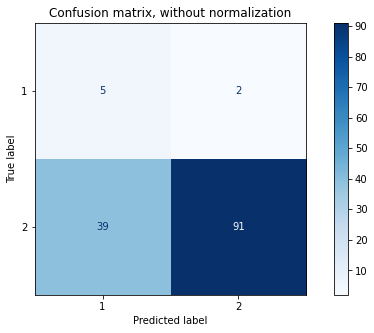

Normalized confusion matrix
[[0.71428571 0.28571429]
 [0.3        0.7       ]]


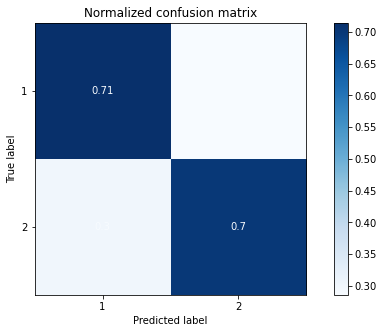

Best model with sigmoid kernel:
SVC(C=1000, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=5.0, decision_function_shape='ovr', degree=3, gamma=0.1,
    kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.6756410256410256
train score: 0.6974358974358974
test score: 0.6379120879120879

cv score: 0.6756410256410256
train score: 0.6048780487804878
test score: 0.5693430656934306

Confusion matrix, without normalization
[[ 5  2]
 [57 73]]


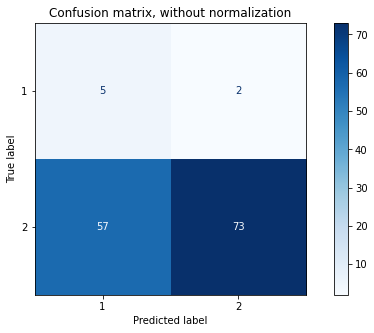

Normalized confusion matrix
[[0.71428571 0.28571429]
 [0.43846154 0.56153846]]


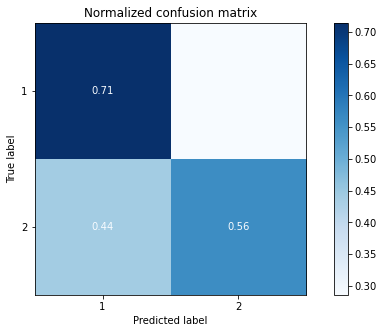

SVM FOR  triangle
poly done
rbf done
sigmoid done
Best model with poly kernel:
SVC(C=0.01, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.6925
train score: 0.6925
test score: 0.625

cv score: 0.6925
train score: 0.9707317073170731
test score: 0.9781021897810219

Confusion matrix, without normalization
[[  1   3]
 [  0 133]]


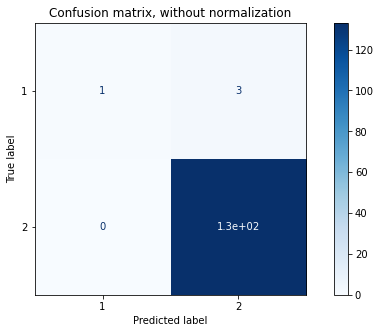

Normalized confusion matrix
[[0.25 0.75]
 [0.   1.  ]]


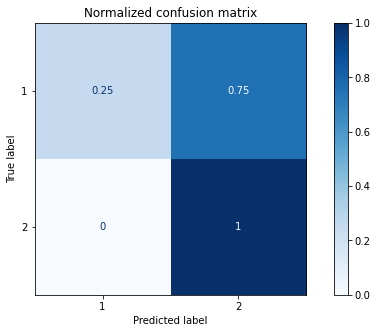

Best model with rbf kernel:
SVC(C=10, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.6825
train score: 0.6775
test score: 0.7161654135338346

cv score: 0.6825
train score: 0.9414634146341463
test score: 0.9197080291970803

Confusion matrix, without normalization
[[  2   2]
 [  9 124]]


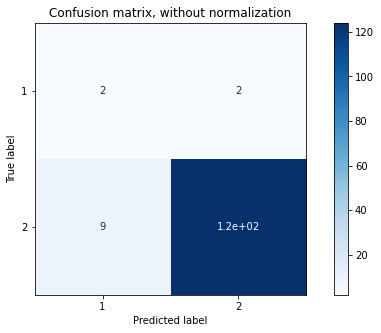

Normalized confusion matrix
[[0.5        0.5       ]
 [0.06766917 0.93233083]]


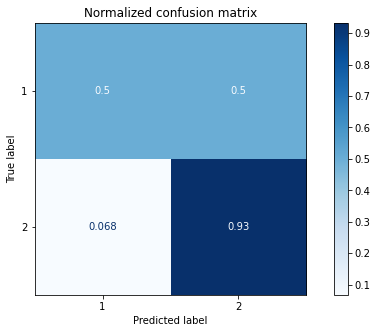

Best model with sigmoid kernel:
SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=-5.0, decision_function_shape='ovr', degree=3, gamma=1,
    kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.6875
train score: 0.685
test score: 0.606203007518797

cv score: 0.6875
train score: 0.9560975609756097
test score: 0.9416058394160584

Confusion matrix, without normalization
[[  1   3]
 [  5 128]]


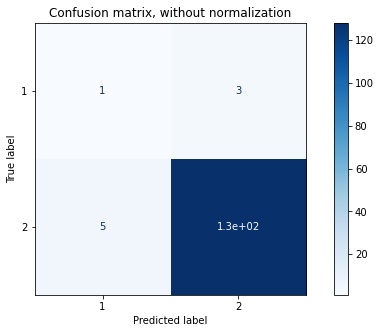

Normalized confusion matrix
[[0.25       0.75      ]
 [0.03759398 0.96240602]]


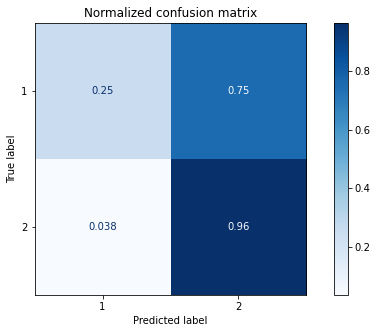

SVM FOR  rett_diag
poly done
rbf done
sigmoid done
Best model with poly kernel:
SVC(C=0.01, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=-10.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.8816666666666666
train score: 0.9263959390862944
test score: 0.9007633587786259

cv score: 0.8816666666666666
train score: 0.8585365853658536
test score: 0.8102189781021898

Confusion matrix, without normalization
[[  6   0]
 [ 26 105]]


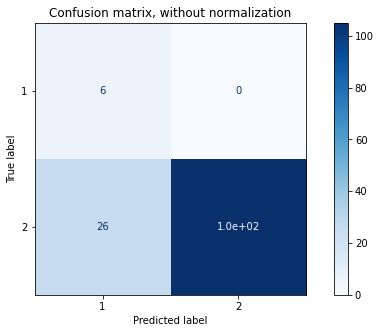

Normalized confusion matrix
[[1.         0.        ]
 [0.19847328 0.80152672]]


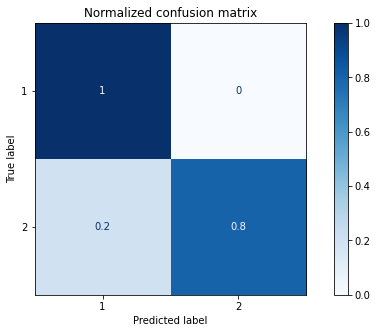

Best model with rbf kernel:
SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.8746794871794872
train score: 0.9095812182741116
test score: 0.772264631043257

cv score: 0.8746794871794872
train score: 0.9414634146341463
test score: 0.8686131386861314

Confusion matrix, without normalization
[[  4   2]
 [ 16 115]]


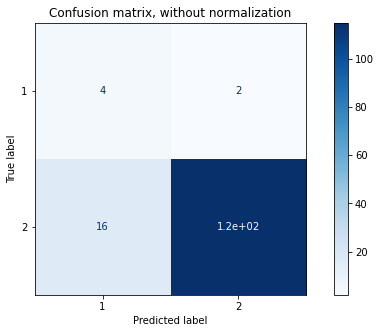

Normalized confusion matrix
[[0.66666667 0.33333333]
 [0.1221374  0.8778626 ]]


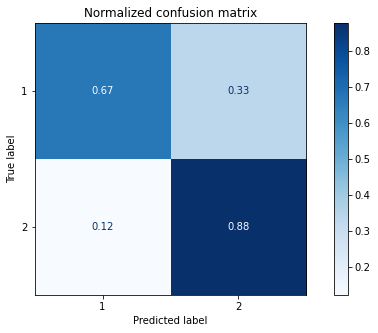

Best model with sigmoid kernel:
SVC(C=1000, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=5.0, decision_function_shape='ovr', degree=3, gamma=0.1,
    kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.923974358974359
train score: 0.934010152284264
test score: 0.9007633587786259

cv score: 0.923974358974359
train score: 0.8731707317073171
test score: 0.8102189781021898

Confusion matrix, without normalization
[[  6   0]
 [ 26 105]]


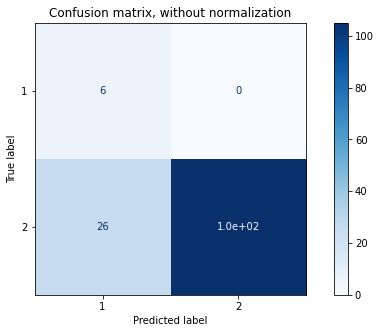

Normalized confusion matrix
[[1.         0.        ]
 [0.19847328 0.80152672]]


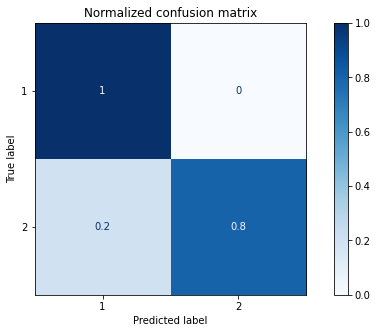

SVM FOR  rect
poly done
rbf done
sigmoid done
Best model with poly kernel:
SVC(C=0.01, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=2, gamma='scale',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.8749358974358975
train score: 0.8940536013400335
test score: 0.6212406015037594

cv score: 0.8749358974358975
train score: 0.9512195121951219
test score: 0.9708029197080292

Confusion matrix, without normalization
[[  1   3]
 [  1 132]]


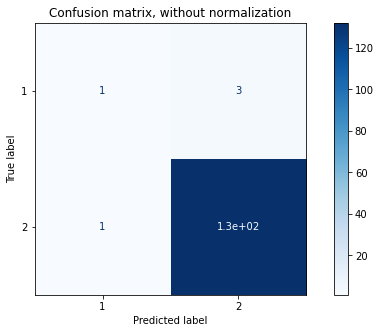

Normalized confusion matrix
[[0.25      0.75     ]
 [0.0075188 0.9924812]]


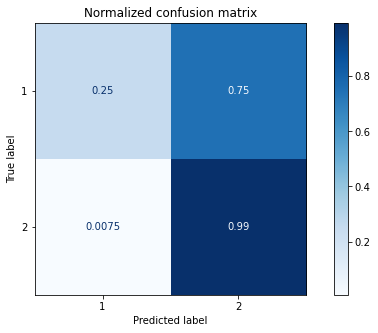

Best model with rbf kernel:
SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
cv score: 0.8824358974358976
train score: 0.8990787269681741
test score: 0.6212406015037594

cv score: 0.8824358974358976
train score: 0.9609756097560975
test score: 0.9708029197080292

Confusion matrix, without normalization
[[  1   3]
 [  1 132]]


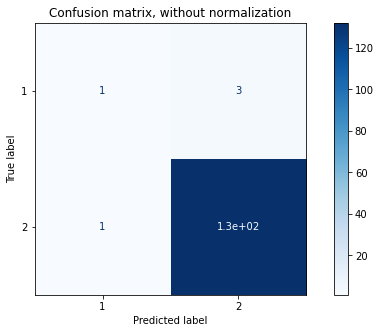

Normalized confusion matrix
[[0.25      0.75     ]
 [0.0075188 0.9924812]]


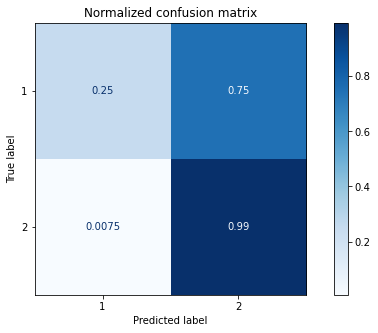

Best model with sigmoid kernel:
SVC(C=0.01, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=-5.0, decision_function_shape='ovr', degree=3, gamma=1,
    kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.8849358974358974
train score: 0.9015912897822446
test score: 0.6212406015037594

cv score: 0.8849358974358974
train score: 0.9658536585365853
test score: 0.9708029197080292

Confusion matrix, without normalization
[[  1   3]
 [  1 132]]


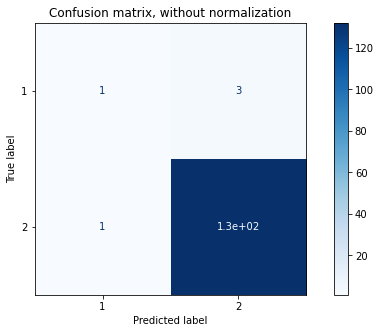

Normalized confusion matrix
[[0.25      0.75     ]
 [0.0075188 0.9924812]]


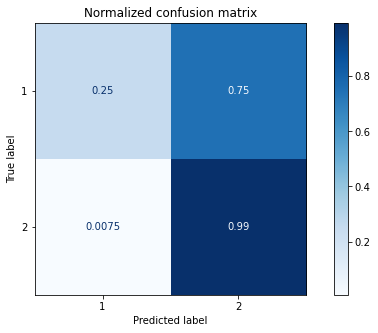

SVM FOR  cross_vert
poly done
rbf done
sigmoid done
Best model with poly kernel:
SVC(C=0.01, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=-10.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.7428205128205129
train score: 0.7902918781725888
test score: 0.8090909090909091

cv score: 0.7428205128205129
train score: 0.7121951219512195
test score: 0.8175182481751825

Confusion matrix, without normalization
[[  4   1]
 [ 24 108]]


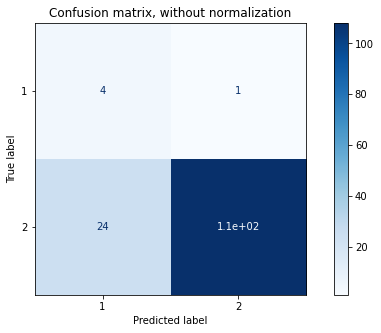

Normalized confusion matrix
[[0.8        0.2       ]
 [0.18181818 0.81818182]]


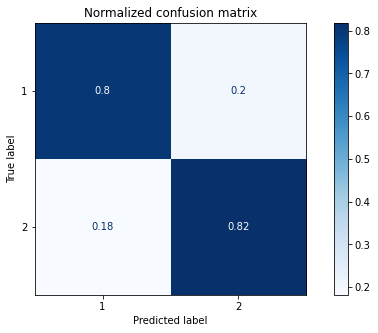

Best model with rbf kernel:
SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
cv score: 0.7284615384615384
train score: 0.7709390862944163
test score: 0.6166666666666667

cv score: 0.7284615384615384
train score: 0.7902439024390244
test score: 0.8175182481751825

Confusion matrix, without normalization
[[  2   3]
 [ 22 110]]


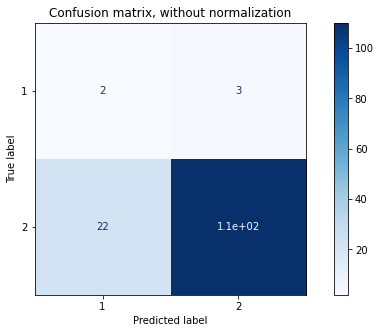

Normalized confusion matrix
[[0.4        0.6       ]
 [0.16666667 0.83333333]]


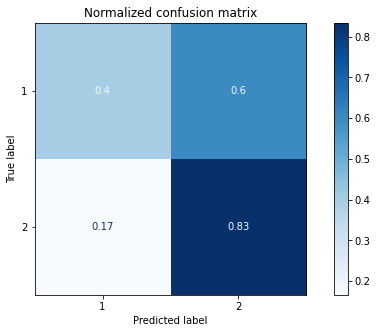

Best model with sigmoid kernel:
SVC(C=1000, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=5.0, decision_function_shape='ovr', degree=3, gamma=0.1,
    kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.7628205128205129
train score: 0.7328680203045685
test score: 0.7825757575757576

cv score: 0.7628205128205129
train score: 0.7170731707317073
test score: 0.7664233576642335

Confusion matrix, without normalization
[[  4   1]
 [ 31 101]]


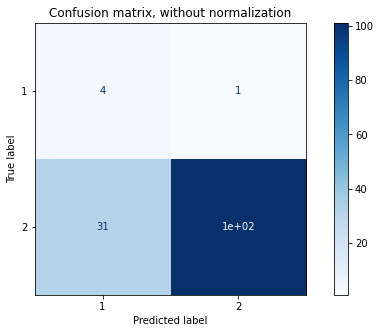

Normalized confusion matrix
[[0.8        0.2       ]
 [0.23484848 0.76515152]]


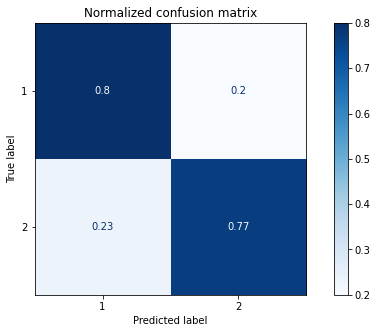

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix, matthews_corrcoef, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions
import joblib
y = y_data
for i in range(len(patterns)):

    print("SVM FOR ", patternsName[i])
    X_pixel = X[i]
    y_current = y[i]
    X_train, X_test, y_train, y_test = train_test_split(X_pixel, y_current, test_size=0.4, random_state=0, stratify=y_current)
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],
        'coef0': np.linspace(-10, 10, 5),
        'degree': [2, 3, 4]}
    svm_poly_pixel = GridSearchCV(SVC(kernel='poly', class_weight='balanced'), param_grid,
                            cv=5, scoring='balanced_accuracy', refit=True)
    svm_poly_pixel.fit(X_train_scaled, y_train)
    print('poly done')
    # RBF
    param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
    rbf_poly_pixel = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, 
                            cv=5, scoring='balanced_accuracy', refit=True)
    rbf_poly_pixel.fit(X_train_scaled, y_train)
    print('rbf done')
    # Sigmoid
    param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'coef0': np.linspace(-10, 10, 5)}
    sigm_poly_pixel = GridSearchCV(SVC(kernel='sigmoid', class_weight='balanced'), param_grid, 
                            cv=5, scoring='balanced_accuracy', refit=True)
    sigm_poly_pixel.fit(X_train_scaled, y_train)
    print('sigmoid done')
    for m in [svm_poly_pixel, rbf_poly_pixel, sigm_poly_pixel]:
        cv_score = m.best_score_
        m = m.best_estimator_  
        print("Best model with {} kernel:".format(m.get_params()['kernel']))    
        print(m)     
        train_acc = balanced_accuracy_score(y_train, m.predict(X_train_scaled))
        test_acc = balanced_accuracy_score(y_test, m.predict(X_test_scaled))
        print("cv score: {}".format(cv_score))
        print("train score: {}".format(train_acc))
        print("test score: {}\n".format(test_acc))
        train_acc = accuracy_score(y_train, m.predict(X_train_scaled))
        test_acc = accuracy_score(y_test, m.predict(X_test_scaled))
        print("cv score: {}".format(cv_score))
        print("train score: {}".format(train_acc))
        print("test score: {}\n".format(test_acc))
        # plot_decision_regions(X_test_scaled, y_test, clf=m, legend=2)
        titles_options = [("Confusion matrix, without normalization", None),
                    ("Normalized confusion matrix", 'true')]
        class_names = ['1', '2']
        for title, normalize in titles_options:
            disp = plot_confusion_matrix(m, X_test_scaled, y_test,
                                        display_labels=class_names,
                                        cmap=plt.cm.Blues,
                                        normalize=normalize)
            disp.ax_.set_title(title)
            print(title)
            print(disp.confusion_matrix)
            plt.show()
            plt.close('all')
        
        # joblib.dump(m, '../new_models/'+ patternsName[i] +'_model_' + m.get_params()['kernel'] + '.joblib')
    # joblib.dump(scaler, '../new_models/'+patternsName[i] +'_scaler.joblib')



In [9]:
for i in range(len(y)):
    print(sum(y[i])/len(y[i]))


0.9122807017543859
0.9502923976608187
0.9502923976608187
0.9736842105263158
0.9590643274853801
0.9707602339181286
0.9619883040935673
